In [1]:
%matplotlib inline
import pathpy as pp
import hypa
import matplotlib.pyplot as plt
import pickle
import numpy as np
from random import random
import draw
from itertools import cycle
cols = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

coupon_fname = "coupons_2018_01-5percent"

In [2]:
paths = pp.Paths()
paths = paths.read_file('../data/{}.ngram'.format(coupon_fname), frequency=True)

2020-10-29 10:01:13 [Severity.INFO]	Reading ngram data ... 
2020-10-29 10:01:16 [Severity.INFO]	finished. Read 88539 paths with maximum length 10


In [3]:
print(paths)

Total path count: 		185871.0 
[Unique / Sub paths / Total]: 	[88539.0 / 1380687.0 / 1566558.0]
Nodes:				382 
Edges:				6933
Max. path length:		10
Avg path length:		2.481656632825992 
Paths of length k = 0		0.0 [ 0.0 / 647139.0 / 647139.0 ]
Paths of length k = 1		29531.0 [ 4667.0 / 431737.0 / 461268.0 ]
Paths of length k = 2		92711.0 [ 33610.0 / 182686.0 / 275397.0 ]
Paths of length k = 3		14358.0 [ 10943.0 / 104699.0 / 119057.0 ]
Paths of length k = 4		44885.0 [ 34961.0 / 10543.0 / 55428.0 ]
Paths of length k = 5		2852.0 [ 2833.0 / 3305.0 / 6157.0 ]
Paths of length k = 6		1374.0 [ 1365.0 / 397.0 / 1771.0 ]
Paths of length k = 7		104.0 [ 104.0 / 133.0 / 237.0 ]
Paths of length k = 8		41.0 [ 41.0 / 36.0 / 77.0 ]
Paths of length k = 9		9.0 [ 9.0 / 12.0 / 21.0 ]
Paths of length k = 10		6.0 [ 6.0 / 0.0 / 6.0 ]



In [4]:
sum([k * v[1] for k,v in paths.path_lengths().items()])

461268.0

# Lambda_1

In [5]:
net = pp.HigherOrderNetwork(paths, k=1, separator=paths.separator)
adj = net.adjacency_matrix(weighted=False).todense()
w,wv = np.linalg.eig(adj)

max(w).real

56.5502833753289

In [6]:
[max(w).real**k/3600 for k in range(2,5)]

[0.8883151527305556, 50.234473613511504, 2840.7737180545573]

# Second order network

In [8]:
hy = hypa.Hypa.from_paths(paths, k=2, log=True)

Computing the k=2 order Xi...
Fitting Xi...
rmse = 6977.366846733035
rmse = 0.0009779261733649722


In [9]:
pnet_edges_sorted = sorted(hy.hypa_net.edges.items(), key = lambda kv: kv[1]['pval'])
pnet_edges_set = set([x[0] for x in pnet_edges_sorted])

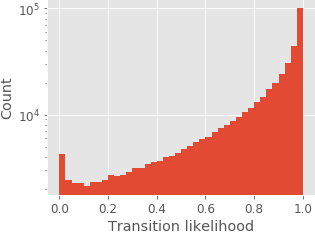

In [10]:
pvals  = []
for e,dat in pnet_edges_sorted:
    pvals.append(dat['pval'])

plt.hist(np.exp(pvals), bins=40, log=True)
# plt.hist((np.exp(pvals),np.exp(pval1).flatten()), bins=40, log=True)
plt.xlabel('Transition likelihood')
plt.ylabel('Count')
plt.show()

# Compare the return flights to others

In [11]:
probs_return = []
probs_other = []
for e,d in hy.hypa_net.edges.items():
    # check if A==C in (A-B)->(B-C)
    if e[0].split(',')[0] == e[1].split(',')[1]:
        probs_return.append(d['pval'])
    else:
        probs_other.append(d['pval'])

# return transitions:		5840
# non-return transitions:	409254


/Users/larock/miniconda3/envs/hypa/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


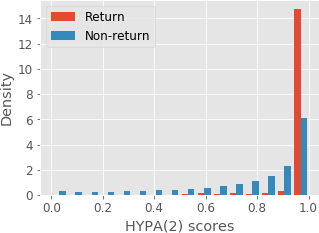

In [12]:
import draw
draw.set_style()


print('# return transitions:\t\t{}'.format(len(probs_return)))
print('# non-return transitions:\t{}'.format(len(probs_other)))

plt.hist((np.exp(probs_return), np.exp(probs_other)),  bins=16,
         log=False, stacked=False, density=True, 
         label=('Return',# ({})'.format(len(probs_return)), 
                'Non-return'))
plt.xlabel('HYPA(2) scores')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('output/flights-returns-diff.pdf')
plt.show()

In [13]:
po = 0.00001
pthr_o = np.log(1-po)
pthr_u = np.log(po)

over_return = np.sum(np.array(probs_return) > pthr_o)
under_return = np.sum(np.array(probs_return) <= pthr_u)

over_other = np.sum(np.array(probs_other) > pthr_o)
under_other = np.sum(np.array(probs_other) <= pthr_u)

print("{:.0e}\t&\t{:.3f}\t&\t{:.3f} \\\\".format(po, over_return/len(probs_return), over_other/len(probs_other)))

print("\t return \t|\t non-return")
print("under \t\t over \t| under \t\t over")
print("{:.1e} \t {:.3f} \t| {:.1e} \t\t {:.3f}".format(
    under_return/len(probs_return), over_return/len(probs_return),
    under_other/len(probs_other), over_other/len(probs_other) ))

1e-05	&	0.628	&	0.001 \\
	 return 	|	 non-return
under 		 over 	| under 		 over
0.0e+00 	 0.628 	| 4.8e-04 		 0.001


In [14]:
over_non_return = []
for e,d in hy.hypa_net.edges.items():
    # check if A!=C in (A-B)->(B-C)
    if e[0].split(',')[0] != e[1].split(',')[1] and d['pval'] > pthr_o:
        over_non_return.append([e, d["weight"], d["xival"], d['pval']])

In [15]:
print(len(over_non_return))
over_non_return = sorted(over_non_return, key=lambda x: x[3], reverse=True)
over_non_return

511


[[('IAH,HNL', 'HNL,GUM'), 20.0, 322316.0, -1.742937551896422e-19],
 [('ATL,ORD', 'ORD,MDW'), 14.0, 129056.0, -5.6841685458694245e-18],
 [('LGA,MCO', 'MCO,JFK'), 25.0, 877312.0, -1.4050157825226132e-15],
 [('ATL,DAL', 'DAL,DFW'), 14.0, 211718.0, -7.204150500164294e-15],
 [('DAL,DFW', 'DFW,ATL'), 11.0, 104295.0, -1.2802662157034681e-14],
 [('ATL,DFW', 'DFW,DAL'), 12.0, 138328.0, -1.3044562732562464e-14],
 [('GUM,HNL', 'HNL,IAH'), 14.0, 224398.0, -1.6512936254006596e-14],
 [('ANC,PDX', 'PDX,MCO'), 12.0, 149545.0, -3.4615340267435315e-14],
 [('ORD,MDW', 'MDW,ATL'), 15.0, 289290.0, -3.912364341368643e-14],
 [('CLT,LAS', 'LAS,DFW'), 27.0, 1202797.0, -4.1259893492807623e-14],
 [('JFK,MIA', 'MIA,LGA'), 35.0, 2055837.0, -5.1637690477783327e-14],
 [('DFW,DAL', 'DAL,ATL'), 14.0, 256031.0, -1.072371228687217e-13],
 [('CLT,FLL', 'FLL,PHL'), 31.0, 1727972.0, -2.9353177296372e-13],
 [('LGA,DEN', 'DEN,ASE'), 17.0, 472245.0, -5.072748423158681e-13],
 [('JFK,DEN', 'DEN,LGA'), 12.0, 196545.0, -1.03201601

# Distance-related hypotheses

In [16]:
import pandas as pd
import geopy.distance as gd

In [17]:
airpdat = pd.read_csv('../data/airport-codes.csv')

isUS = (airpdat.iso_country == 'US')
hasCoors = airpdat.coordinates.apply(lambda x: len(x) > 8)
hasIATA = airpdat.iata_code.notnull()

airpdat = airpdat[isUS & hasCoors & hasIATA]

airpdat.coordinates = airpdat.coordinates.apply(
    lambda x: gd.lonlat(*x.split(', ')))

In [18]:
iata_coord = {row['iata_code']: row['coordinates'] for idx, row in airpdat.iterrows()}

In [19]:
for e,edat in hy.hypa_net.edges.items():
    a = e[0].split(',')[0]
    b = e[0].split(',')[1]
    c = e[1].split(',')[1]

    try:
        ainf, binf, cinf = (iata_coord[i] for i in (a,b,c))
    except KeyError:
        continue

    hy.hypa_net.edges[e]['dist12'] = gd.distance(ainf, binf).km
    hy.hypa_net.edges[e]['dist23'] = gd.distance(binf, cinf).km
    hy.hypa_net.edges[e]['dist13'] = gd.distance(ainf, cinf).km

### Efficiency

In [20]:
def compute_rel_dist(dat):
    return dat['dist13']/(dat['dist12'] + dat['dist23'])
    
pval_vs_dist = []
for e,dat in hy.hypa_net.edges.items():
    if "dist12" in dat:
        pval_vs_dist.append([compute_rel_dist(dat), dat['pval']])

pval_vs_dist = np.array(pval_vs_dist)

In [21]:
n_bins = 16
dist_bins = np.arange(0,1+1/n_bins, 1/n_bins)
p_binned = [[] for b in dist_bins]
for rd,pv in pval_vs_dist:
    p_binned[np.argmax(rd <= dist_bins)].append(pv)

In [22]:
po = pu = 0.05
# po = 0.05 # alpha_u
over_binned = [np.sum(np.array(b) > np.log(1-po))/len(b) for b in p_binned]
under_binned = [np.sum(np.array(b) < np.log(pu))/len(b) for b in p_binned]

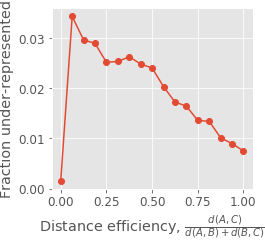

In [23]:
draw.set_style()
ccc = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] =  [4, 3.6]

plt.plot(dist_bins, under_binned, 'o-', c=ccc[0])
plt.xlabel("Distance efficiency, $\\frac{d(A,C)}{d(A,B) + d(B,C)}$")
plt.ylabel("Fraction under-represented")
plt.ylim((0, 1.05*max(under_binned)))

plt.tight_layout()
plt.savefig('output/rel-dist-underrep.pdf')
plt.show()

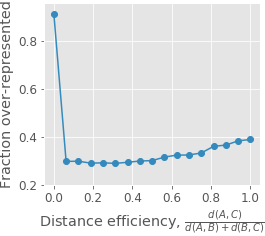

In [24]:
draw.set_style()
plt.rcParams['figure.figsize'] =  [4, 3.6]

plt.plot(dist_bins, np.array(over_binned), 'o-', c=ccc[1])
plt.xlabel("Distance efficiency, $\\frac{d(A,C)}{d(A,B) + d(B,C)}$")
plt.ylabel("Fraction over-represented")
plt.ylim((0.2, 1.05*max(over_binned)))

plt.tight_layout()
plt.savefig('output/rel-dist-overrep.pdf')

### Balance

In [25]:
def compute_length_balance(dat):
    return (dat['dist12'] - dat['dist23'])/(dat['dist12'] + dat['dist23'])
    
pval_vs_lratio = []
for e,dat in hy.hypa_net.edges.items():
    if "dist12" in dat:
        pval_vs_lratio.append([compute_length_balance(dat), dat['pval']])

pval_vs_lratio = np.array(pval_vs_lratio)

/Users/larock/miniconda3/envs/hypa/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


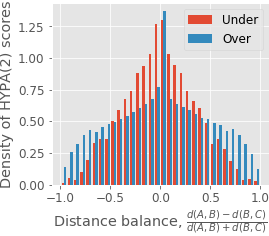

In [26]:
# pu = 0.01
# po = 0.01
draw.set_style()
plt.rcParams['figure.figsize'] =  [4, 3.6]

lru = (pval_vs_lratio[:,1] < np.log(pu))
lro = (pval_vs_lratio[:,1] > np.log(1-po))
mid = np.logical_and(~lru, ~lro)
lrnoo = (pval_vs_lratio[:,1] < np.log(1-po))

plt.hist((pval_vs_lratio[lru,0], pval_vs_lratio[lro,0]),
         label=('Under','Over'),
         bins=32, density=True)

plt.xlabel("Distance balance, $\\frac{d(A,B) - d(B,C)}{d(A,B) + d(B,C)}$")
plt.ylabel("Density of HYPA(2) scores")
plt.legend()
plt.tight_layout()
plt.savefig('output/distance-balance.pdf')
plt.show()